In [1]:
from scipy.sparse import coo_matrix
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import ast
import pickle 

In [ ]:
'''visual_embd = {}
with open("dict_1000_vit.pickle", "rb") as f:
    visual_embd = pickle.load(f) 
bp()
synopsis_embd = {}
with open("sentence_embeddings_mpnet.pickle", "rb") as f:
    synopsis_embd = pickle.load(f) 
bp()
print("HEY")'''

In [2]:
animes_data_path = "preprocessed_animes.csv"
profiles_data_path = "preprocessed_profiles.csv"
reviews_data_path = "preprocessed_reviews.csv"
animes_data = pd.read_csv(animes_data_path)
profiles_data = pd.read_csv(profiles_data_path)
reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)

animes = animes_data.copy()
profiles = profiles_data.copy()
reviews = reviews_data.copy()

<ipython-input-2-7df933736d05>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)


In [3]:
np.random.seed(0)
unique_AnimeID = reviews['anime_uid'].unique().tolist()
unique_users = reviews['profile'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_users:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
movie_new2old_id_dict = dict()
for i in unique_AnimeID:
    movie_old2new_id_dict[i] = j
    movie_new2old_id_dict[j] = i
    j += 1

In [4]:
user_list = reviews['profile'].values
movie_list = reviews['anime_uid'].values
for j in range(len(reviews)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
reviews['profile'] = user_list
reviews['anime_uid'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(reviews)) <= 0.7
train_df = reviews[train_index]
test_df = reviews[~train_index]

# generate train_mat and test_mat
num_user = len(reviews['profile'].unique())
num_items = len(reviews['anime_uid'].unique())

train_mat = coo_matrix((train_df['score'].values, (train_df['profile'].values, train_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()
test_mat = coo_matrix((test_df['score'].values, (test_df['profile'].values, test_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()

In [5]:
def MF_PreTrained_Embeddings(latent_factors, num_epochs):
  P = np.random.rand(num_user, latent_factors)
  Q = np.random.rand(latent_factors, num_items)

  a = 0.01
  b = 0.1
  train_loss = []
  test_loss = []
  nonzero_indices_train = np.nonzero(train_mat)
  nonzero_indices_test = np.nonzero(test_mat)

  for epoch in range(num_epochs):
      for i in range(num_user):
          for j in range(num_items):
              if train_mat[i, j] > 0:
                  diff = train_mat[i, j] - np.dot(P[i, :], Q[:, j])
                  P[i, :] += a * (diff * Q[:, j] - b * P[i, :])
                  Q[:, j] += a * (diff * P[i, :] - b * Q[:, j])

      predicted_matrix = np.dot(P, Q)
      
      rmse_train = np.sqrt(np.mean((predicted_matrix[nonzero_indices_train] - train_mat[nonzero_indices_train])**2))
      rmse_test = np.sqrt(np.mean((predicted_matrix[nonzero_indices_test] - test_mat[nonzero_indices_test])**2))

      train_loss.append(rmse_train)
      test_loss.append(rmse_test)

      print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
      print('RMSE Train Loss: {:.4f}'.format(rmse_train), end=', ')
      print('RMSE Test Loss: {:.4f}'.format(rmse_test))
    
  return P, Q

In [6]:
latent_factors_for_MF = 24
num_epochs = 5
P1, Q1 = MF_PreTrained_Embeddings(latent_factors_for_MF, num_epochs)

Epoch 1 of 5: RMSE Train Loss: 1.8094, RMSE Test Loss: 2.0557
Epoch 2 of 5: RMSE Train Loss: 1.5989, RMSE Test Loss: 1.9685
Epoch 3 of 5: RMSE Train Loss: 1.4802, RMSE Test Loss: 1.9379
Epoch 4 of 5: RMSE Train Loss: 1.3959, RMSE Test Loss: 1.9260
Epoch 5 of 5: RMSE Train Loss: 1.3279, RMSE Test Loss: 1.9225


In [7]:
import math 

popularity_list = [math.log(popularity, 2) + 0.000001 for popularity in animes['popularity'].tolist()]
score = animes['score'].tolist()

In [8]:
indices_train = np.argwhere(train_mat > 0)
train_df = {'user_id': [], 'item_id': [], 'rating': [], 'item_features': []}
for index in indices_train:
  train_df['user_id'].append(index[0])
  train_df['item_id'].append(index[1])
  train_df['rating'].append(train_mat[index[0], index[1]])
  train_df['item_features'].append([1 / popularity_list[index[1]], score[index[1]] / 100])

indices_test = np.argwhere(test_mat > 0)
test_df = {'user_id': [], 'item_id': [], 'rating': [], 'item_features': []}
for index in indices_test:
  test_df['user_id'].append(index[0])
  test_df['item_id'].append(index[1])
  test_df['rating'].append(test_mat[index[0], index[1]])
  test_df['item_features'].append([1 / popularity_list[index[1]], score[index[1]] / 100])

In [9]:
train_df = pd.DataFrame(train_df)
print(train_df.head())

test_df = pd.DataFrame(test_df)
print(test_df.head())

   user_id  item_id  rating                               item_features
0        0        0     8.0               [0.14006480387583592, 0.0882]
1        0       69     6.0               [0.08490645695377619, 0.0788]
2        0      106     7.0                [0.1042080160150738, 0.0791]
3        0      119     8.0  [0.08835499833417422, 0.07919999999999999]
4        0      167     7.0               [0.08674556677079649, 0.0796]
   user_id  item_id  rating                  item_features
0        0        1     8.0  [0.20801455440644562, 0.0883]
1        0       94     6.0   [0.08625950625710395, 0.079]
2        0      147     9.0  [0.08992088617901264, 0.0794]
3        0      196     7.0  [0.08455551647372916, 0.0799]
4        0      237     7.0  [0.12637607214413166, 0.0802]


In [10]:
from torch.utils.data import DataLoader, TensorDataset
train_user_ids = torch.LongTensor(train_df['user_id'].values)
train_item_ids = torch.LongTensor(train_df['item_id'].values)
train_ratings = torch.FloatTensor(train_df['rating'].values)
train_item_features = torch.FloatTensor(train_df['item_features'])

train_dataset = TensorDataset(train_user_ids, train_item_ids, train_ratings, train_item_features)
batch_size = 256

# Create a DataLoader that generates batches of data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_user_ids = torch.LongTensor(test_df['user_id'].values)
test_item_ids = torch.LongTensor(test_df['item_id'].values)
test_ratings = torch.FloatTensor(test_df['rating'].values)
test_item_features = torch.FloatTensor(test_df['item_features'])

test_dataset = TensorDataset(test_user_ids, test_item_ids, test_ratings, test_item_features)

# Create a DataLoader that generates batches of data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim, item_features_dim, pretrained_user_embs, pretrained_item_embs):
        super(NCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.item_features_dim = item_features_dim
        
        # User and item embeddings
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        
        self.fc1 = nn.Linear(embedding_dim * 2 + item_features_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        if pretrained_user_embs is not None:
            self.user_embed.weight.data.copy_(torch.from_numpy(pretrained_user_embs))
        if pretrained_item_embs is not None:
            self.item_embed.weight.data.copy_(torch.from_numpy(pretrained_item_embs)) 

        
    def forward(self, user, item, item_features):
        # Embedding lookup
        user_embed = self.user_embed(user)
        item_embed = self.item_embed(item)
        
        # Concatenate the user and item embeddings
        x = None
        if self.item_features_dim == 0:
          x = torch.cat([user_embed, item_embed], dim=1)
        else:
          x = torch.cat([user_embed, item_embed, item_features], dim=1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Apply sigmoid function to output
        x = torch.sigmoid(x) * 10
        
        return x.squeeze(), self.user_embed, self.item_embed


In [12]:
from pandas._libs.tslibs.offsets import QuarterOffset
# Define the model, loss function, and optimizer
import matplotlib.pyplot as plt

def train_NCF(item_features_dim, lr, num_epochs, hidden_dim, latent_factors, P, Q):
  embedding_dim = latent_factors
  
  model = NCF(num_user, num_items, embedding_dim, hidden_dim, item_features_dim, P, Q)
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  # Training loop
  train_loss = []
  test_loss = []
  user_latent = None
  item_latent = None

  for epoch in range(num_epochs):
      model.train()
      running_train_loss = []
      for batch in train_dataloader:
          # Unpack the batch
          user, item, rating, item_features = batch
          
          # Forward pass
          rating_pred, user_embed, item_embed = model(user, item, item_features)
          loss = loss_fn(rating_pred, rating)
          running_train_loss.append(np.sqrt(loss.item()))
          
          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
      model.eval()
      running_test_loss = []

      with torch.no_grad():
        for batch in test_dataloader:
          user, item, rating, item_features = batch
          rating_pred, _, _ = model(user, item, item_features)
          loss = loss_fn(rating_pred, rating)
          running_test_loss.append(np.sqrt(loss.item()))
      
      print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
      print('RMSE Train Loss: {:.4f}'.format(np.mean(running_train_loss)), end=', ')
      print('RMSE Test Loss: {:.4f}'.format(np.mean(running_test_loss)))

      train_loss.append(np.mean(running_train_loss))
      test_loss.append(np.mean(running_test_loss))

      if min(test_loss) == np.mean(running_test_loss):
        user_latent = user_embed
        item_latent = item_embed

  x = [i + 1 for i in range(num_epochs)]
  plt.plot(x, train_loss, label='train_loss')
  plt.plot(x, test_loss, label='test_loss')
  leg = plt.legend(loc='upper center')
  plt.xticks([i + 1 for i in range(0, num_epochs, 3)]) 
  plt.show()

  return user_latent, item_latent

### Baseline NCF

Epoch 1 of 10: RMSE Train Loss: 2.1390, RMSE Test Loss: 2.0107
Epoch 2 of 10: RMSE Train Loss: 1.8256, RMSE Test Loss: 1.9340
Epoch 3 of 10: RMSE Train Loss: 1.6406, RMSE Test Loss: 1.9197
Epoch 4 of 10: RMSE Train Loss: 1.5211, RMSE Test Loss: 1.9517
Epoch 5 of 10: RMSE Train Loss: 1.4222, RMSE Test Loss: 1.9726
Epoch 6 of 10: RMSE Train Loss: 1.3426, RMSE Test Loss: 2.0013
Epoch 7 of 10: RMSE Train Loss: 1.2768, RMSE Test Loss: 2.0208
Epoch 8 of 10: RMSE Train Loss: 1.2215, RMSE Test Loss: 2.0259
Epoch 9 of 10: RMSE Train Loss: 1.1815, RMSE Test Loss: 2.0364
Epoch 10 of 10: RMSE Train Loss: 1.1524, RMSE Test Loss: 2.0643


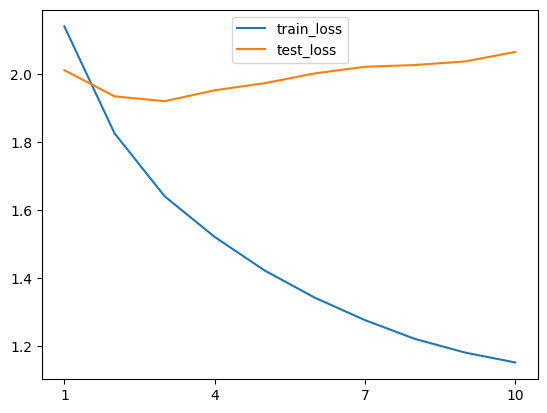

In [57]:
item_features_dim = 0
lr = 0.01
num_epochs = 10
hidden_dim = 64
latent_factors = 32

U, V = train_NCF(item_features_dim, lr, num_epochs, hidden_dim, latent_factors, None, None)

### NCF + MF Hybrid (Uses pretrained embeddings of MF)

Epoch 1 of 10: RMSE Train Loss: 2.1230, RMSE Test Loss: 2.0793
Epoch 2 of 10: RMSE Train Loss: 1.9145, RMSE Test Loss: 1.9517
Epoch 3 of 10: RMSE Train Loss: 1.7294, RMSE Test Loss: 1.8839
Epoch 4 of 10: RMSE Train Loss: 1.6228, RMSE Test Loss: 1.8570
Epoch 5 of 10: RMSE Train Loss: 1.5637, RMSE Test Loss: 1.8552
Epoch 6 of 10: RMSE Train Loss: 1.5254, RMSE Test Loss: 1.8561
Epoch 7 of 10: RMSE Train Loss: 1.4964, RMSE Test Loss: 1.8647
Epoch 8 of 10: RMSE Train Loss: 1.4708, RMSE Test Loss: 1.8641
Epoch 9 of 10: RMSE Train Loss: 1.4473, RMSE Test Loss: 1.8687
Epoch 10 of 10: RMSE Train Loss: 1.4275, RMSE Test Loss: 1.8721


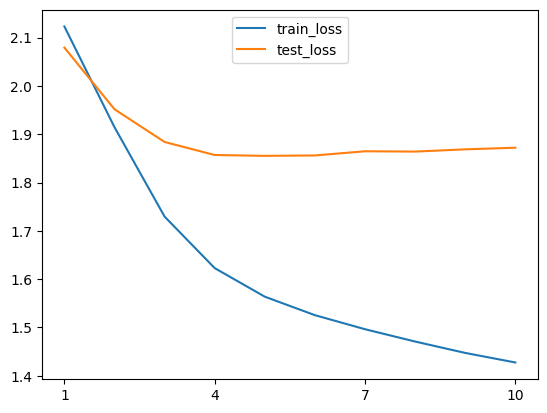

(Embedding(10692, 24), Embedding(6787, 24))

In [ ]:
item_features_dim = 0
lr = 0.0005
num_epochs = 10
latent_factors = latent_factors_for_MF
hidden_dim = 64
train_NCF(item_features_dim, lr, num_epochs, hidden_dim, latent_factors, P1, Q1.T)

### NCF + Item Features

Epoch 1 of 30: RMSE Train Loss: 2.3516, RMSE Test Loss: 2.2307
Epoch 2 of 30: RMSE Train Loss: 2.1892, RMSE Test Loss: 2.1857
Epoch 3 of 30: RMSE Train Loss: 2.1210, RMSE Test Loss: 2.1403
Epoch 4 of 30: RMSE Train Loss: 2.0474, RMSE Test Loss: 2.0959
Epoch 5 of 30: RMSE Train Loss: 1.9745, RMSE Test Loss: 2.0683
Epoch 6 of 30: RMSE Train Loss: 1.9063, RMSE Test Loss: 2.0436
Epoch 7 of 30: RMSE Train Loss: 1.8442, RMSE Test Loss: 2.0241
Epoch 8 of 30: RMSE Train Loss: 1.7878, RMSE Test Loss: 2.0103
Epoch 9 of 30: RMSE Train Loss: 1.7346, RMSE Test Loss: 2.0077
Epoch 10 of 30: RMSE Train Loss: 1.6875, RMSE Test Loss: 1.9951
Epoch 11 of 30: RMSE Train Loss: 1.6442, RMSE Test Loss: 1.9916
Epoch 12 of 30: RMSE Train Loss: 1.6024, RMSE Test Loss: 1.9920
Epoch 13 of 30: RMSE Train Loss: 1.5650, RMSE Test Loss: 1.9908
Epoch 14 of 30: RMSE Train Loss: 1.5305, RMSE Test Loss: 1.9882
Epoch 15 of 30: RMSE Train Loss: 1.4978, RMSE Test Loss: 1.9933
Epoch 16 of 30: RMSE Train Loss: 1.4679, RMSE Tes

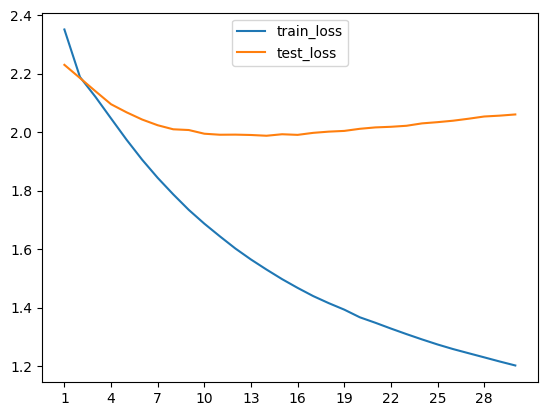

(Embedding(10692, 24), Embedding(6787, 24))

In [61]:
item_features_dim = 2
lr=0.001
num_epochs = 30
latent_factors = latent_factors_for_MF
train_NCF(item_features_dim, lr, num_epochs, hidden_dim, latent_factors, None, None)

In [51]:
import torch
import torch.nn as nn

class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, U, V, P, Q, embedding_dim=32, mf_latent=24, layers=[8, 4, 2], dropout=0.3):
        super(NeuMF, self).__init__()
        
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)

        self.user_emb2 = nn.Embedding(num_users, mf_latent)
        self.item_emb2 = nn.Embedding(num_items, mf_latent)
        
        self.mlp_layers = []
        in_dim = 2 * embedding_dim
        for layer_size in layers:
            self.mlp_layers.append(nn.Linear(in_dim, layer_size))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.Dropout(p=dropout))
            in_dim = layer_size
        
        self.mf_user = nn.Linear(mf_latent, mf_latent)
        self.mf_item = nn.Linear(mf_latent, mf_latent)
        
        self.pred_layer = nn.Linear(in_dim + mf_latent, 1)
        
        if U is not None:
            self.user_emb.weight.data.copy_(U.weight.data)
        if V is not None:
            self.item_emb.weight.data.copy_(V.weight.data)
        if P is not None:
            self.user_emb2.weight.data.copy_(torch.from_numpy(P))
        if Q is not None:
            self.item_emb2.weight.data.copy_(torch.from_numpy(Q))
        
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        
        mlp_in = torch.cat([user_emb, item_emb], dim=1)
        for layer in self.mlp_layers:
            mlp_in = layer(mlp_in)
        
        mf_user_emb = self.user_emb2(user)
        mf_item_emb = self.item_emb2(item)

        mf_in = mf_user_emb * mf_item_emb
        
        pred_in = torch.cat([mlp_in, mf_in], dim=1)
        prediction = torch.sigmoid(self.pred_layer(pred_in)) * 10
        
        return prediction.squeeze()

In [40]:
def train_NeuMF(lr, num_epochs, latent_factors, U, V, P, Q):
  embedding_dim = latent_factors
  model = NeuMF(num_user, num_items, U, V, P, Q, embedding_dim)
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_loss = []
  test_loss = []
  for epoch in range(num_epochs):
      model.train()
      running_train_loss = []
      for batch in train_dataloader:
          user, item, rating, item_features = batch
          
          rating_pred = model(user, item)
          loss = loss_fn(rating_pred, rating)
          running_train_loss.append(np.sqrt(loss.item()))
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
      model.eval()
      running_test_loss = []

      with torch.no_grad():
        for batch in test_dataloader:
          user, item, rating, item_features = batch
          rating_pred = model(user, item)
          loss = loss_fn(rating_pred, rating)
          running_test_loss.append(np.sqrt(loss.item()))
      
      print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
      print('RMSE Train Loss: {:.4f}'.format(np.mean(running_train_loss)), end=', ')
      print('RMSE Test Loss: {:.4f}'.format(np.mean(running_test_loss)))

      train_loss.append(np.mean(running_train_loss))
      test_loss.append(np.mean(running_test_loss))

  x = [i + 1 for i in range(num_epochs)]
  plt.plot(x, train_loss, label='train_loss')
  plt.plot(x, test_loss, label='test_loss')
  leg = plt.legend(loc='upper center')
  plt.xticks([i + 1 for i in range(0, num_epochs, 3)]) 
  plt.show()

Epoch 1 of 10: RMSE Train Loss: 2.0922, RMSE Test Loss: 2.0501
Epoch 2 of 10: RMSE Train Loss: 1.8538, RMSE Test Loss: 1.9634
Epoch 3 of 10: RMSE Train Loss: 1.7110, RMSE Test Loss: 1.8966
Epoch 4 of 10: RMSE Train Loss: 1.5884, RMSE Test Loss: 1.8651
Epoch 5 of 10: RMSE Train Loss: 1.4937, RMSE Test Loss: 1.8492
Epoch 6 of 10: RMSE Train Loss: 1.4140, RMSE Test Loss: 1.8489
Epoch 7 of 10: RMSE Train Loss: 1.3459, RMSE Test Loss: 1.8562
Epoch 8 of 10: RMSE Train Loss: 1.2837, RMSE Test Loss: 1.8622
Epoch 9 of 10: RMSE Train Loss: 1.2228, RMSE Test Loss: 1.8735
Epoch 10 of 10: RMSE Train Loss: 1.1688, RMSE Test Loss: 1.8832


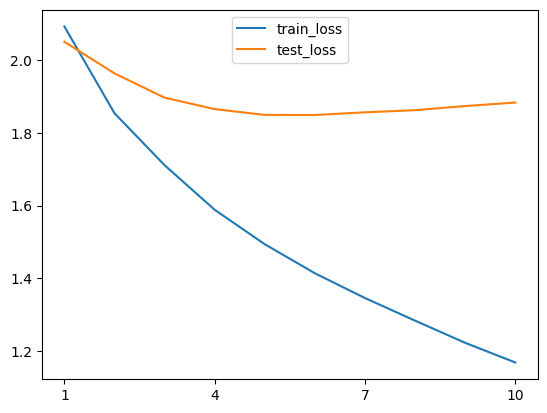

In [60]:
lr=0.001
num_epochs = 10
latent_factors = 32
train_NeuMF(lr, num_epochs, latent_factors, U, V, P1, Q1.T)